# Požymių (angl. *features*) sudarymas

Standartizuojame duomenis kurie buvo atrinkti korelecijos metu. juos naudosime tolimesnėje analizėje klasterizavimo metodams

In [52]:
import os
import numpy as np

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.mllib.linalg import DenseVector, Vectors

In [53]:
with open("../output/columns_selected__agg_usage.txt") as f:
    columns = f.read().split(",")

In [54]:
aggregatedUsageDF = (
    sqlContext.read.format("com.databricks.spark.csv")
    .options(inferSchema=True, header=False)
    .load("../output/selected_customer_usage/")
    .rdd
    .toDF(columns)  
)

In [55]:
#aggregatedUsageDF = aggregatedUsageDF.limit(10)

Apsirašome funkciją, kuri priima pyspark.sql.DataFrame ir jo požymių stulpelio pavadinimą (pagal nulylėjimą "features") ir grąžina pyspark.sql.DataFrame, kurio požymių stulpelis yra paverstas į pyspark.mllib.linalg.DenseVector tipą, jeigu prieš tai jis buvo pyspark.mllib.linalg.SparseVector tipo. Kitu atveju gražinamas nemodifikuotas pyspark.sql.DataFrame.

In [56]:
def ensureDenseFeatures(featurizedDF, featuresCol="features"):
    columns = featurizedDF.columns
    idxCol = columns.index(featuresCol)
    transformedRow = pyspark.sql.Row(*columns)
    
    def rowColumnSparseToDense(row):
        values = list(row)
        values[idxCol] = pyspark.mllib.linalg.DenseVector(row[idxCol].toArray())
        return transformedRow(*values)
    
    if not isinstance(featurizedDF.first()[idxCol], DenseVector):
        featurizedDF = featurizedDF.rdd.map(rowColumnSparseToDense).toDF()
    
    return featurizedDF

Atrenkame tolydžiuosius kintamuosius

In [57]:
with open("../output/columns_continuous__agg_usage.txt") as f:
    continouosColumns = f.read().split(",")

In [58]:
continuousColsSelected = [c for c in columns if c in continouosColumns]

## Požymių vektorių sudarymas

In [59]:
assembler = VectorAssembler(inputCols=continuousColsSelected, outputCol="features")
featurizedDF = assembler.transform(aggregatedUsageDF)
featurizedDF.first()

Row(reloads_sum=0.0, calls_outgoing_count=4.666666666666667, calls_outgoing_to_offnet_inactive_days=6.0, calls_outgoing_to_abroad_inactive_days=6.0, sms_outgoing_to_onnet_spendings=0.0, sms_outgoing_to_abroad_spendings=0.0, last_100_reloads_count=0.0, last_100_sms_outgoing_to_onnet_count=0.0, last_100_sms_outgoing_to_abroad_count=0.0, features=SparseVector(9, {1: 4.6667, 2: 6.0, 3: 6.0}))

## Požymių standartizavimas

In [60]:
scaler = StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")
scalerModelOrg = scaler.fit(featurizedDF)

In [61]:
featuresEnsuredDF = ensureDenseFeatures(featurizedDF)

In [62]:
scalerModelEnsured = scaler.fit(featurizedDF)

In [63]:
featurizedScaledDF = scalerModelOrg.transform(featurizedDF)

In [64]:
featurizedScaledEnsuredDF = scalerModelEnsured.transform(featuresEnsuredDF)

In [65]:
scalerModel = scalerModelEnsured
featurizedScaledDF = featurizedScaledEnsuredDF

In [66]:
featurizedScaledDF.select("scaled_features").take(10)

[Row(scaled_features=DenseVector([-0.5641, -0.5064, -0.4047, -0.4047, -0.2065, -0.2057, -0.5852, -0.1928, -0.2109])),
 Row(scaled_features=DenseVector([-0.0456, -0.1733, -0.4129, -0.4129, -0.1314, -0.2057, 0.8767, -0.0865, -0.1408])),
 Row(scaled_features=DenseVector([-0.5641, -0.5466, -0.3793, -0.3793, -0.2065, -0.2057, -0.5852, -0.1928, -0.1759])),
 Row(scaled_features=DenseVector([-0.3503, -0.4088, -0.4055, -0.4055, -0.0563, -0.2057, -0.0229, -0.0245, -0.2109])),
 Row(scaled_features=DenseVector([1.4205, 5.4256, -0.4178, -0.4178, -0.2065, -0.2057, 0.6518, -0.1928, -0.2109])),
 Row(scaled_features=DenseVector([0.3989, -0.1561, -0.4006, -0.4006, -0.2065, 2.9078, -0.0792, 0.7195, 7.7753])),
 Row(scaled_features=DenseVector([-0.0223, 0.4067, -0.417, -0.417, -0.2065, -0.2057, 0.5394, -0.1928, -0.2109])),
 Row(scaled_features=DenseVector([-0.5641, -0.4662, -0.3949, -0.3949, -0.2065, -0.2057, -0.4728, -0.1928, -0.1233])),
 Row(scaled_features=DenseVector([-0.2434, -0.5523, -0.3687, -0.3687

### Isaugomi standartizuoti duomenys

In [67]:
! rm -rf ../Output/featurized_customer_usage/

In [68]:
featurizedScaledDF.write.format("com.databricks.spark.csv").save("../Output/featurized_customer_usage")

In [69]:
with open("../Output/columns_featurized__agg_usage.txt", "w") as f:
    f.write(",".join(featurizedScaledDF.columns))

# K-vidurkių modelis naudojant pyspark.mllib.clustering.KMeans

In [70]:
from pyspark import mllib
import pyspark.ml.feature
import pyspark.ml.clustering
import pyspark.ml.classification
import pyspark.ml.evaluation
import pyspark.mllib.feature
import pyspark.mllib.clustering
import ggplot as gg
import pandas as pd

In [71]:
def predictKMeans(x, centers):
    return min(
        (i for i in range(len(centers))), 
        key=lambda i: (x - centers[i]).norm(2))

In [72]:
def addKMeansPredictionToDataFrame(df, featuresCol, predictionCol, kMeansModelCenters):
    return (
        df.rdd
        .map(lambda r: addKMeansPredictionToRow(r, featuresCol, kMeansModelCenters))
        .toDF(df.columns + [predictionCol])
    )

def addKMeansPredictionToRow(row, featuresCol, kMeansModelCenters):
    features = row.asDict()[featuresCol]
    return row + (predictKMeans(features, kMeansModelCenters),)

pyspark.mllib naudojami RDD, o ne DataFrame objektai, todėl sukuriame normalizuotų požymių RDD:

In [73]:
featurizedScaledRDD = (
    featurizedScaledDF.select("scaled_features").rdd
    .map(lambda r: r[0])
)

Peržiūrimas grafinis duomenų išsidėstymas dvimatėje erdvėje

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43313 entries, 0 to 43312
Data columns (total 11 columns):
reloads_sum                               43313 non-null float64
calls_outgoing_count                      43313 non-null float64
calls_outgoing_to_offnet_inactive_days    43313 non-null float64
calls_outgoing_to_abroad_inactive_days    43313 non-null float64
sms_outgoing_to_onnet_spendings           43313 non-null float64
sms_outgoing_to_abroad_spendings          43313 non-null float64
last_100_reloads_count                    43313 non-null float64
last_100_sms_outgoing_to_onnet_count      43313 non-null float64
last_100_sms_outgoing_to_abroad_count     43313 non-null float64
features                                  43313 non-null object
scaled_features                           43313 non-null object
dtypes: float64(9), object(2)
memory usage: 3.6+ MB


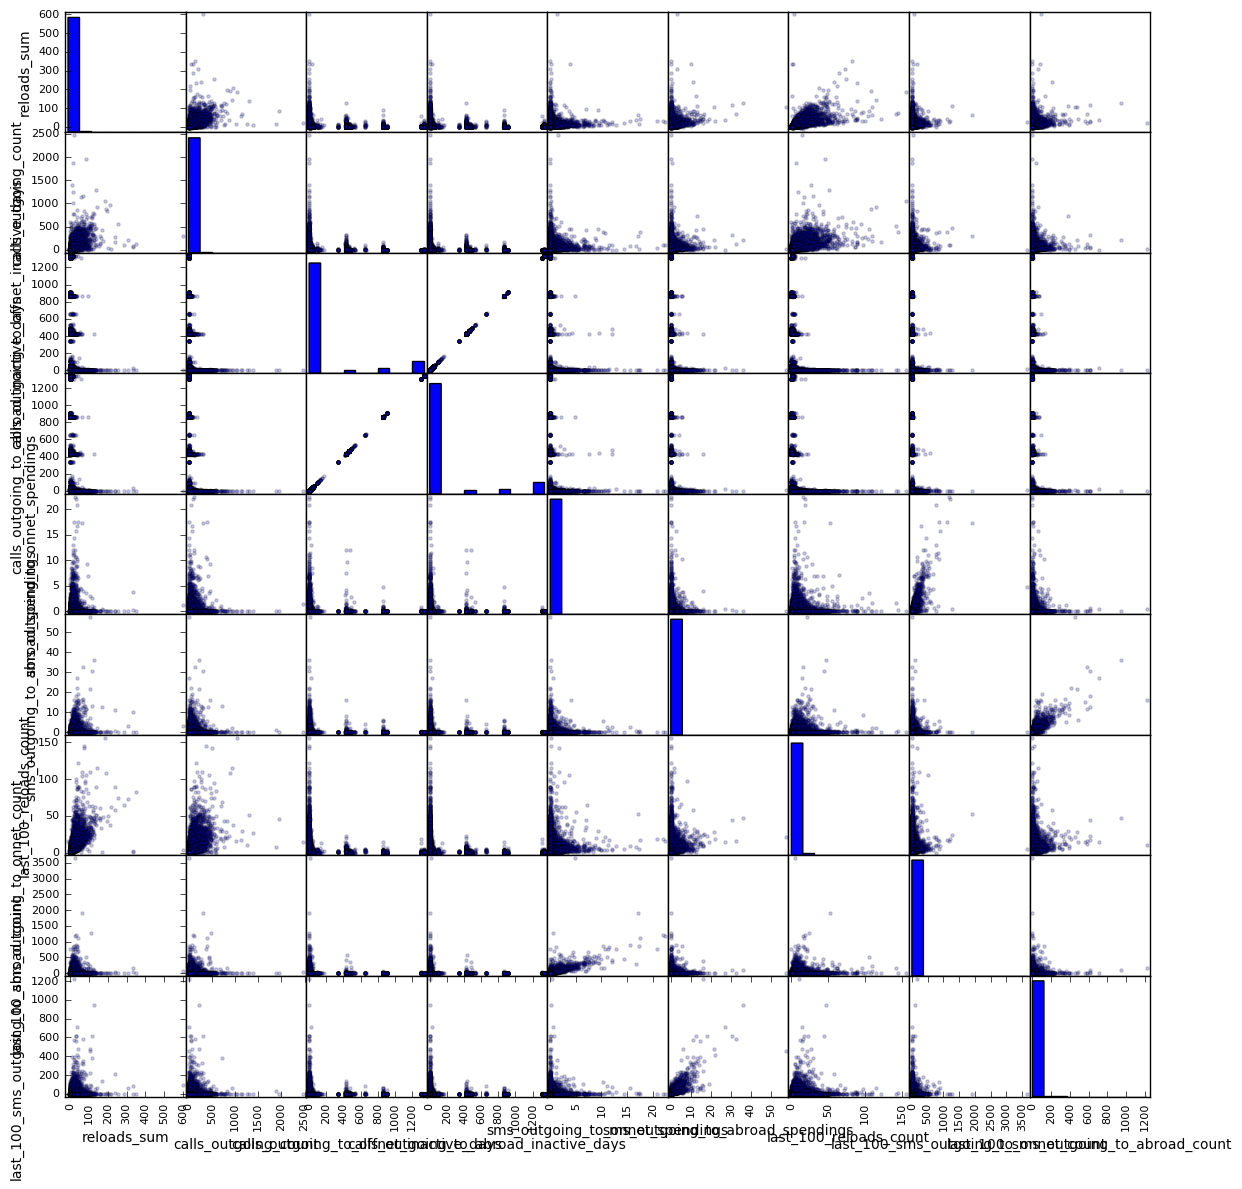

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
%matplotlib inline
featurizedScaledPandasDF = featurizedScaledDF.toPandas()

scatter_matrix(featurizedScaledPandasDF, alpha=0.2, figsize=(14, 14), diagonal='hist')
featurizedScaledPandasDF.info()

/home/ubuntu/.miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


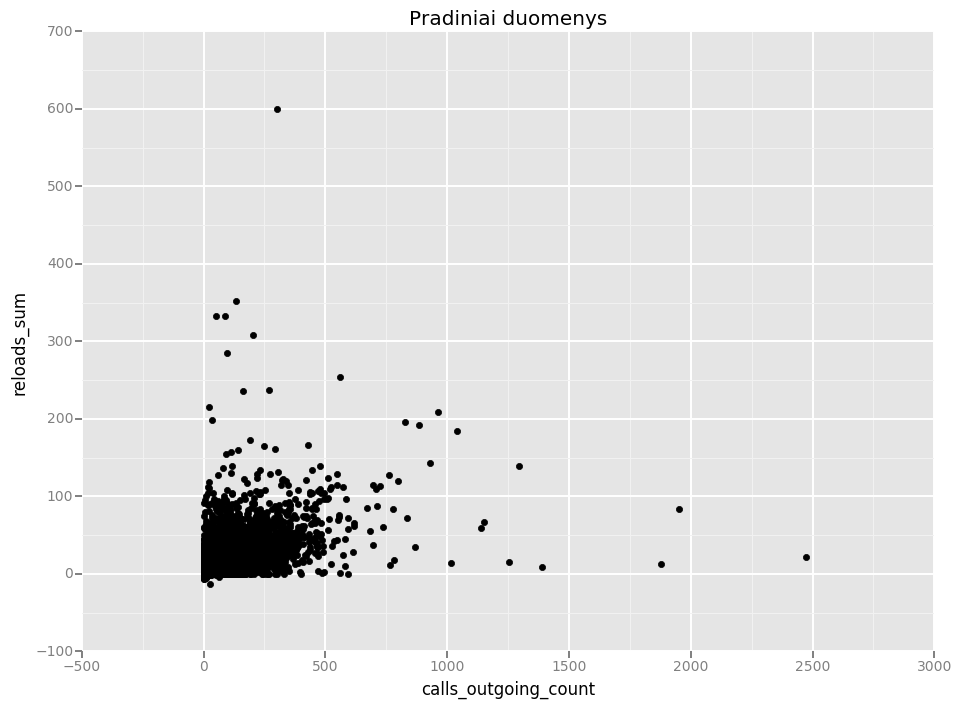

<ggplot: (8751498994075)>

In [95]:
(
    gg.ggplot(gg.aes(x="calls_outgoing_count", y="reloads_sum"), data=featurizedScaledDF.select(["calls_outgoing_count", "reloads_sum"]).toPandas()) + 
    gg.geom_point() + 
    gg.ggtitle("Pradiniai duomenys")
)

Pažiūrime stebėjimų skaičius ir klasių pasiskirstymą pagal klasterį:

In [75]:
ks = list(range(1, 10))

In [76]:
kMllibModelPairs = [
    (k, mllib.clustering.KMeans.train(featurizedScaledRDD, k=k)) 
    for k in ks
]

In [77]:
kMllibCostPairs = [
    (k, model.computeCost(featurizedScaledRDD)) 
    for k, model in kMllibModelPairs
]

In [78]:
kMllibCostPdDf = pd.DataFrame.from_records(
    kMllibCostPairs, 
    columns=["k", "SSE"])
kMllibCostPdDf

k            SSE
0  1  389808.000000
1  2  323298.438192
2  3  241959.091600
3  4  206240.085250
4  5  172119.057557
5  6  154165.221834
6  7  137630.182084
7  8  131958.578238
8  9  120402.762932

/home/ubuntu/.miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


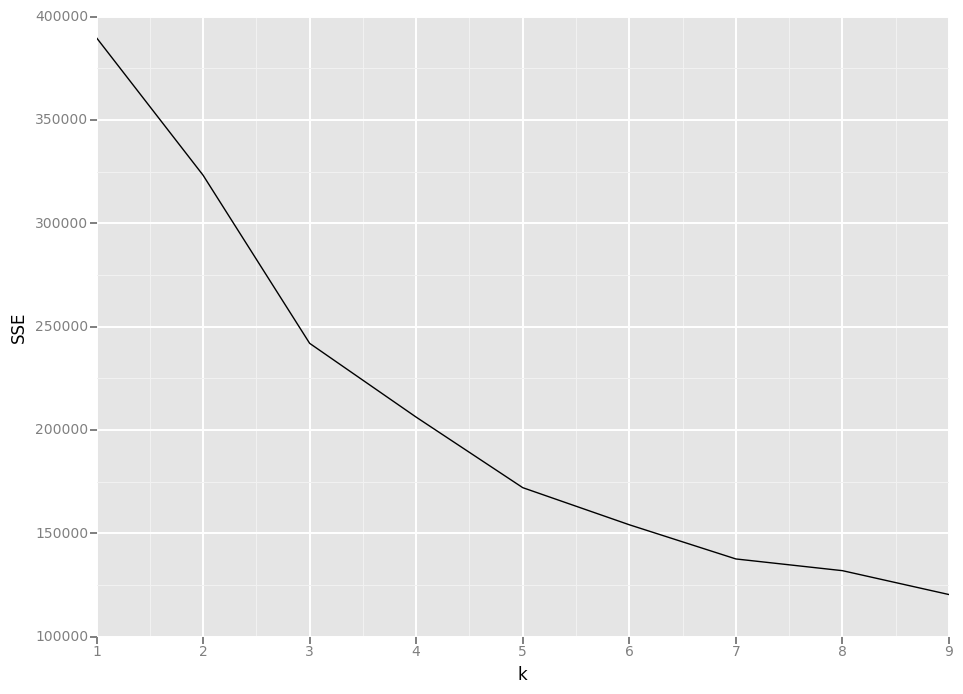

<ggplot: (8751497924051)>

In [79]:
gg.ggplot(kMllibCostPdDf, gg.aes(x="k", y="SSE")) + gg.geom_line()

## $f(K)$ metrikos panaudojimas K-vidurkių klasterizavimo rezultatams

In [80]:
%matplotlib inline

$f(K)$ yra naudojama nustatyti optimalią $K$ reikšmę

In [81]:
def computeFK(k, SSE, prevSSE, dim):
    if k == 1 or prevSSE == 0:
        return 1
    weight = weightFactor(k, dim)
    return SSE / (weight * prevSSE)

# calculating alpha_k in functional style with tail recursion -- which is not optimized in Python :(
def weightFactor(k, dim):
    if not k >= 2:
        raise ValueError("k should be greater than 1.")
        
    def weightFactorAccumulator(acc, k):
        if k == 2:
            return acc
        return weightFactorAccumulator(acc + (1 - acc) / 6, k - 1)
        
    k2Weight = 1 - 3 / (4 * dim)
    return weightFactorAccumulator(k2Weight, k)

Aprašome funkciją, kuri iš $K$ ir $S_K$ reikšmių porų `list`'o pateikia galimas įvertinti $f(K)$ reikšmes.

In [82]:
def computeFKs(ksAndSSEPairs, dimension):
    triples = makeFkTriples(ksAndSSEPairs)
    ksWithFks = [
        (k, computeFK(k, Sk, prevSk, dimension))
        for (k, Sk, prevSk) in triples]
    return sorted(ksWithFks, key=lambda pair: pair[0])


def makeFkTriples(ksAndSSEPairs):
    sortedPairs = sorted(ksAndSSEPairs, reverse=True)
    candidates = list(zip(sortedPairs, sortedPairs[1:]))
    triples = [
        (k, SSE, prevSSE)
        for ((k, SSE), (prevK, prevSSE)) in candidates
        if k - prevK == 1
    ]
    return triples

In [83]:
# reikia žinoti duomenų dimensiją
dimension = 9 

ksAndSSEPairs = list(map(tuple, kMllibCostPdDf.to_records(index=False)))
ksAndSSEPairs

[(1, 389807.99999999983),
 (2, 323298.43819205929),
 (3, 241959.0916000198),
 (4, 206240.08525048924),
 (5, 172119.05755737744),
 (6, 154165.22183416181),
 (7, 137630.18208423536),
 (8, 131958.57823833826),
 (9, 120402.7629315879)]

In [84]:
ksWithFks = computeFKs(ksAndSSEPairs, dimension)
ksWithFks

[(2, 0.90477672418326072),
 (3, 0.80425919061329187),
 (4, 0.90473308404209807),
 (5, 0.87684277454117709),
 (6, 0.93319234480313229),
 (7, 0.92367848861806345),
 (8, 0.98631729334074114),
 (9, 0.93415389865803822)]

In [85]:
ksWithFksPdDF = pd.DataFrame.from_records(ksWithFks, columns=["K", "fK"])
ksWithFksPdDF

K        fK
0  2  0.904777
1  3  0.804259
2  4  0.904733
3  5  0.876843
4  6  0.933192
5  7  0.923678
6  8  0.986317
7  9  0.934154

/home/ubuntu/.miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


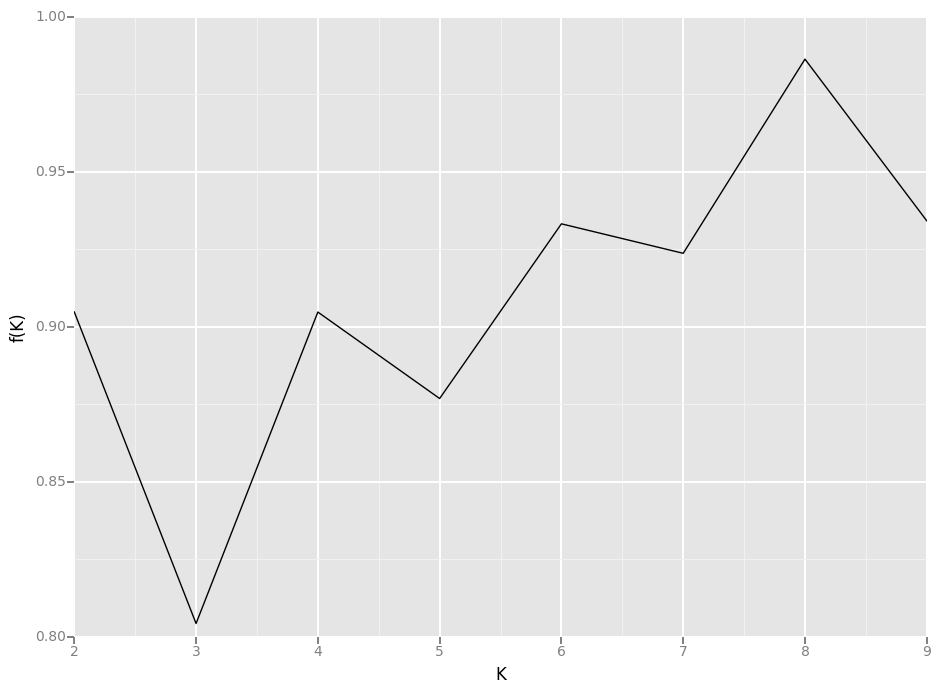

<ggplot: (-9223363285355116372)>

In [86]:
gg.ggplot(gg.aes(x="K", y="fK"), data=ksWithFksPdDF) + gg.geom_line() + gg.ylab("f(K)")

Atliekame klasterizavima parinkus 4 klasteriu sprendini:

## Klasterių analizė / interpretavimas

In [87]:
k = 5
kmeansModelMllib = mllib.clustering.KMeans.train(featurizedScaledRDD, k=k)

In [88]:
cluster = featurizedScaledRDD.map(lambda r: kmeansModelMllib.predict(r))

In [89]:
cluster = featurizedScaledRDD.map(lambda r: kmeansModelMllib.predict(r))

swp = lambda x: (x[1], x[0])

dataDf = (cluster.zipWithIndex().map(swp)
          .join(aggregatedUsageDF.rdd.zipWithIndex().map(swp))
          .values().toDF(["cluster", "point"])
          .select("cluster", "point.*"))

atliekame duomenu agregavima pagal klasterius tam, kad galima butu interpretuoti juos ir aiskiai susigaudyti kas kokias grupes sudaro ir ar nereikalingi pakeitimai. Sudaromas "dictionary" kur raktas Klusterio numeris.

/home/ubuntu/.miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


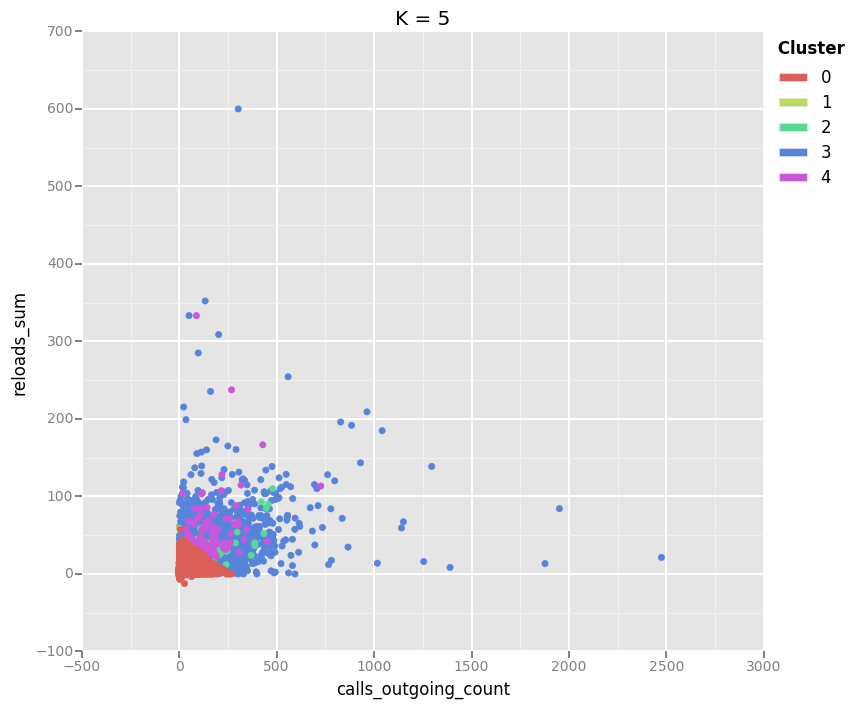

<ggplot: (-9223363285354470077)>

In [94]:
(
    gg.ggplot(gg.aes(x="calls_outgoing_count", y="reloads_sum", color="cluster"), data=dataDf.toPandas()) + 
    gg.geom_point() + 
    gg.ggtitle("K = 5")
)

In [96]:
clusterRange = list(range(0, 5))

In [97]:
clusterDescribeDictionary = {
    c: dataDf.filter(dataDf.cluster == c).describe().toPandas().T
    for c in clusterRange
}

In [98]:
clusterDescribeDictionary[0]

0                    1  \
summary                                 count                 mean   
cluster                                 33678                  0.0   
reloads_sum                             33678    5.060738959162257   
calls_outgoing_count                    33678   26.118747154423264   
calls_outgoing_to_offnet_inactive_days  33678   21.928237029118897   
calls_outgoing_to_abroad_inactive_days  33678   21.928237029118897   
sms_outgoing_to_onnet_spendings         33678  0.08446612031593323   
sms_outgoing_to_abroad_spendings        33678  0.11180503592849936   
last_100_reloads_count                  33678   2.4450284062790755   
last_100_sms_outgoing_to_onnet_count    33678    5.269973474275991   
last_100_sms_outgoing_to_abroad_count   33678   2.7060989369915065   

                                                         2  \
summary                                             stddev   
cluster                                                0.0   
reloads_sum                              5.755228529620875   
calls_outgoing_count                    26.663708545572344   
calls_outgoing_to_offnet_inactive_days     80.391511830609   
calls_outgoing_to_abroad_inactive_days     80.391511830609   
sms_outgoing_to_onnet_spendings         0.2647297840506591   
sms_outgoing_to_abroad_spendings        0.3480312334387898   
last_100_reloads_count                  2.5705671167899755   
last_100_sms_outgoing_to_onnet_count    15.846583877012735   
last_100_sms_outgoing_to_abroad_count    7.786927785668298   

                                                          3  \
summary                                                 min   
cluster                                                   0   
reloads_sum                             -12.469999999999999   
calls_outgoing_count                                    0.0   
calls_outgoing_to_offnet_inactive_days                  0.0   
calls_outgoing_to_abroad_inactive_days                  0.0   
sms_outgoing_to_onnet_spendings                         0.0   
sms_outgoing_to_abroad_spendings                        0.0   
last_100_reloads_count                                  0.0   
last_100_sms_outgoing_to_onnet_count                    0.0   
last_100_sms_outgoing_to_abroad_count                   0.0   

                                                         4  
summary                                                max  
cluster                                                  0  
reloads_sum                                           57.5  
calls_outgoing_count                     268.3333333333333  
calls_outgoing_to_offnet_inactive_days               654.0  
calls_outgoing_to_abroad_inactive_days               654.0  
sms_outgoing_to_onnet_spendings                       3.36  
sms_outgoing_to_abroad_spendings                      4.68  
last_100_reloads_count                                21.0  
last_100_sms_outgoing_to_onnet_count     289.6666666666667  
last_100_sms_outgoing_to_abroad_count   135.66666666666666